# This notebook aims to answer the question of whether or not weather data has an impact on price volatility, as represented by the coefficient of variation in price.

In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

!pip install us
import us

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/Shareddrives/Data606_Energy/data/weather

/content/drive/Shareddrives/Data606_Energy/data/weather


In [ ]:
df = pd.read_csv('../merge_ready/merged_data.csv')

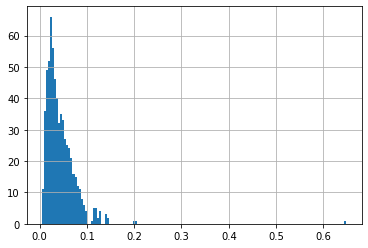

In [ ]:
# first, let's look at the target variable
df['target_COV'].hist(bins=150)

In [ ]:
# there are a lot of outliers, so I will use 3 standard deviations above the mean to capture these values
outlier_thresh = df['target_COV'].mean() + 3*df['target_COV'].std()
print(outlier_thresh)

0.15314526603219974


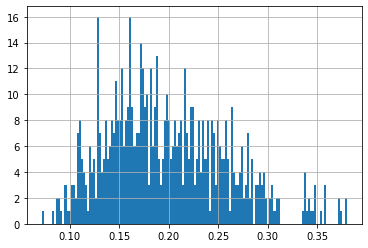

In [ ]:
# the target variable should be normally distribute so I should try to take the square root
df.query('target_COV < '+str(outlier_thresh))['target_COV'].pow(0.5).hist(bins=150)

## Weather Data and Target Variable

In [ ]:
summary_files = ['temperature_summary.csv','drought_summary.csv','weighted_temperature_summary.csv','weighted_drought_summary.csv',
                 'log_weighted_temperature_summary.csv','log_weighted_drought_summary.csv']

monthly_state_standardized_files = ['standardized_temperatures_state.csv','standardized_droughts_state.csv','weighted_standardized_temperatures_state.csv',
                                    'weighted_standardized_droughts_state.csv','log_weighted_standardized_temperatures_state.csv',
                                    'log_weighted_standardized_droughts_state.csv']

hot_cold_dry_files = ['annual_weather_data.csv','annual_weather_data_weighted.csv','annual_weather_data_log_weighted.csv']

In [ ]:
def join_files(file_list):
  all_data = pd.read_csv(file_list[0])
  for f in file_list[1:]:
    print("All Data Shape: {}".format(all_data.shape))
    print("new data shape: {}".format(pd.read_csv(f).shape))
    try:
      all_data = pd.merge(all_data,pd.read_csv(f,index_col=None),on=['State','Year'],how='outer').reset_index(drop=True)
    except:
      try:
        all_data = pd.merge(all_data,pd.read_csv(f,index_col=None),on='State',how='outer').reset_index(drop=True)
      except Exception as e:
        print(e)
  return all_data

In [ ]:
weather_summary_data = join_files(summary_files)

All Data Shape: (50, 26)
new data shape: (50, 26)
All Data Shape: (50, 51)
new data shape: (50, 26)
All Data Shape: (50, 76)
new data shape: (50, 26)
All Data Shape: (50, 101)
new data shape: (50, 26)
All Data Shape: (50, 126)
new data shape: (50, 26)


In [ ]:
# add the target variable
weather_COV = df.query('target_COV < '+str(outlier_thresh))[['State','Year','target_COV']].copy()
weather_COV['target_COV'] = weather_COV['target_COV'].pow(0.5)
weather_COV = pd.merge(weather_summary_data,weather_COV,on='State',how='outer')

In [ ]:
log_columns = []
pop_columns = []
reg_columns = []
for col in weather_COV.columns:
  if 'Log' in col:
    log_columns.append(col)
  elif 'Pop' in col:
    pop_columns.append(col)
  elif 'Temp' in col or 'Drought' in col:
    reg_columns.append(col)

print("Average correlation with log population weighting: {}".format(weather_COV[log_columns+['target_COV']].corr()['target_COV'].abs().mean()))
print("Average correlation with population weighting: {}".format(weather_COV[pop_columns+['target_COV']].corr()['target_COV'].abs().mean()))
print("Average correlation with no weighting: {}".format(weather_COV[reg_columns+['target_COV']].corr()['target_COV'].abs().mean()))

Average correlation with log population weighting: 0.1456278243890399
Average correlation with population weighting: 0.1427598201000133
Average correlation with no weighting: 0.16073022687026406


In [ ]:
# print out the top correlations
weather_COV.corr()['target_COV'].abs().sort_values(ascending=False)[:30]

target_COV                            1.000000
Temp Standard Deviations 4            0.317424
Drought Log Pop Averages 12           0.303493
Drought Log Pop Averages 8            0.303184
Drought Log Pop Averages 2            0.301706
Drought Log Pop Averages 9            0.300542
Drought Pop Averages 8                0.299207
Drought Pop Averages 2                0.297623
Drought Log Pop Averages 3            0.296888
Drought Pop Averages 9                0.295841
Drought Log Pop Averages 1            0.292299
Drought Averages 12                   0.290776
Drought Pop Averages 12               0.289476
Temp Log Pop Standard Deviations 4    0.288086
Temp Pop Standard Deviations 4        0.287862
Drought Pop Averages 3                0.286845
Drought Log Pop Averages 10           0.284264
Drought Pop Averages 1                0.284128
Drought Averages 8                    0.281518
Temp Averages 7                       0.278699
Drought Averages 9                    0.276600
Drought Pop A

It looks like most of the highest correlations are with weather summary metrics weighted with the logarithm of the population density.

In [ ]:
log_columns = []
for col in weather_COV.columns:
  if 'Log' in col:
    log_columns.append(col)

In [ ]:
weather_COV[log_columns+['target_COV']].corr()['target_COV'].sort_values(ascending=False)

target_COV                                1.000000
Drought Log Pop Averages 12               0.303493
Drought Log Pop Averages 8                0.303184
Drought Log Pop Averages 2                0.301706
Drought Log Pop Averages 9                0.300542
Drought Log Pop Averages 3                0.296888
Drought Log Pop Averages 1                0.292299
Temp Log Pop Standard Deviations 4        0.288086
Drought Log Pop Averages 10               0.284264
Drought Log Pop Averages 4                0.257957
Drought Log Pop Averages 11               0.252615
Drought Log Pop Averages 7                0.247934
Drought Log Pop Averages 5                0.244256
Drought Log Pop Averages 6                0.226247
Drought Log Pop Standard Deviations 4     0.191528
Temp Log Pop Standard Deviations 8        0.171182
Drought Log Pop Standard Deviations 2     0.162257
Temp Log Pop Standard Deviations 6        0.138240
Drought Log Pop Standard Deviations 5     0.136997
Drought Log Pop Standard Deviat

The best looking variables are drought values, especially for the month of September.

In [ ]:
# for comparison, see the correlation with unweighted
weather_COV[['Drought Averages 12','target_COV']].corr()

,Drought Averages 12,target_COV
Drought Averages 12,1.000000,0.290776
target_COV,0.290776,1.000000


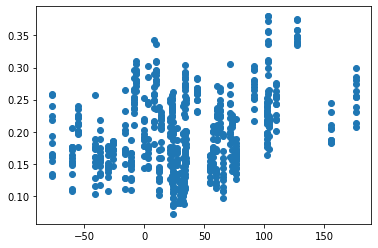

In [ ]:
plt.scatter(weather_COV['Drought Averages 12'],weather_COV['target_COV'])

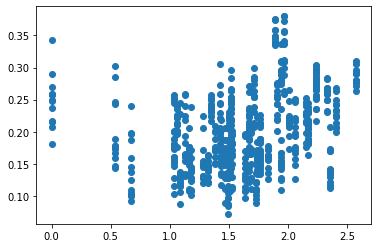

In [ ]:
plt.scatter(weather_COV['Temp Log Pop Standard Deviations 4'],weather_COV['target_COV'])

## Now look at the standardized temperatures and drought indices by each year and state, having one column per month

In [ ]:
monthly_standardized_data = join_files(monthly_state_standardized_files)

All Data Shape: (1100, 15)
new data shape: (1050, 15)
All Data Shape: (1100, 28)
new data shape: (1100, 15)
All Data Shape: (1100, 41)
new data shape: (1050, 15)
All Data Shape: (1100, 54)
new data shape: (1100, 15)
All Data Shape: (1100, 67)
new data shape: (1050, 15)


In [ ]:
# add the target variable
standardized_COV = df.query('target_COV < '+str(outlier_thresh))[['State','Year','target_COV']].copy()
standardized_COV['target_COV'] = standardized_COV['target_COV'].pow(0.5)
standardized_COV = pd.merge(monthly_standardized_data,standardized_COV,on=['Year','State'],how='outer')

In [ ]:
log_columns = []
pop_columns = []
reg_columns = []
for col in standardized_COV.columns:
  if 'Log' in col:
    log_columns.append(col)
  elif 'Pop' in col:
    pop_columns.append(col)
  elif 'Temp' in col or 'Drought' in col:
    reg_columns.append(col)

print("Average correlation with log population weighting: {}".format(standardized_COV[log_columns+['target_COV']].corr()['target_COV'].abs().mean()))
print("Average correlation with population weighting: {}".format(standardized_COV[pop_columns+['target_COV']].corr()['target_COV'].abs().mean()))
print("Average correlation with no weighting: {}".format(standardized_COV[reg_columns+['target_COV']].corr()['target_COV'].abs().mean()))

Average correlation with log population weighting: 0.12727492319827272
Average correlation with population weighting: 0.12998490531766987
Average correlation with no weighting: 0.12472742229593718


In [ ]:
# print out the top correlations
standardized_COV.corr()['target_COV'].abs().sort_values(ascending=False)[7:30]

Temp 6                0.151615
Temp Pop 6            0.147500
Temp Log Pop 6        0.145559
Drought Pop 4         0.135932
Drought Pop 10        0.129495
Drought Pop 6         0.128193
Drought Log Pop 10    0.125481
Drought Pop 3         0.125189
Drought Pop 2         0.124894
Drought Log Pop 4     0.123111
Drought 10            0.120907
Drought Pop 7         0.119459
Drought Pop 5         0.118288
Drought Pop 11        0.118079
Drought Log Pop 2     0.116151
Drought Log Pop 3     0.116016
Drought Log Pop 6     0.115921
Drought Log Pop 11    0.114601
Drought Pop 8         0.114138
Drought 4             0.114012
Drought Pop 12        0.112734
Drought 11            0.112016
Drought Log Pop 8     0.111740
Name: target_COV, dtype: float64

Here it doesn't look like using a simple population weighting works slightly better.

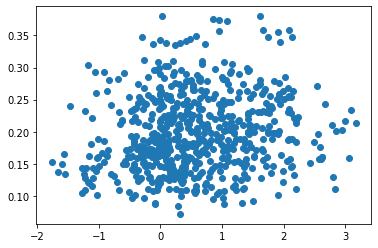

In [ ]:
plt.scatter(standardized_COV['Temp Pop 6'], standardized_COV['target_COV'])

## Now look at the number of hot and cold months

In [ ]:
hot_cold_data = join_files(hot_cold_dry_files)

All Data Shape: (1050, 6)
new data shape: (1050, 6)
All Data Shape: (1050, 10)
new data shape: (1050, 6)


In [ ]:
# add the target variable
hot_cold_COV = df.query('target_COV < '+str(outlier_thresh))[['State','Year','target_COV']].copy()
hot_cold_COV['target_COV'] = hot_cold_COV['target_COV'].pow(0.5)
hot_cold_COV = pd.merge(hot_cold_data,hot_cold_COV,on='State',how='outer')

In [ ]:
log_columns = []
pop_columns = []
reg_columns = []
for col in hot_cold_COV.columns:
  if 'Log' in col:
    log_columns.append(col)
  elif 'Pop' in col:
    pop_columns.append(col)
  elif 'Months' in col:
    reg_columns.append(col)

print("Average correlation with log population weighting: {}".format(hot_cold_COV[log_columns+['target_COV']].corr()['target_COV'].abs().mean()))
print("Average correlation with population weighting: {}".format(hot_cold_COV[pop_columns+['target_COV']].corr()['target_COV'].abs().mean()))
print("Average correlation with no weighting: {}".format(hot_cold_COV[reg_columns+['target_COV']].corr()['target_COV'].abs().mean()))

Average correlation with log population weighting: 0.28430724993160467
Average correlation with population weighting: 0.28272561578570465
Average correlation with no weighting: 0.28660390680715564


In [ ]:
# print out the top correlations
hot_cold_COV[log_columns+pop_columns+reg_columns+['target_COV']].corr()['target_COV'].abs().sort_values(ascending=False)[:30]

target_COV                            1.000000
Pop Dry Summer Months                 0.095619
Log Pop Log Pop Dry Summer Months     0.094482
Dry Summer Months                     0.088878
Hot Summer Months                     0.031075
Log Pop Log Pop Hot Summer Months     0.030020
Pop Hot Summer Months                 0.027548
Cold Winter Months                    0.026463
Log Pop Log Pop Cold Winter Months    0.012727
Pop Cold Winter Months                0.007735
Name: target_COV, dtype: float64

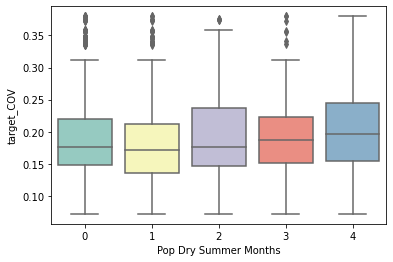

In [ ]:
sns.boxplot(x="Pop Dry Summer Months", y="target_COV",
                 data=hot_cold_COV, palette="Set3")

In [ ]:
pd.read_csv(hot_cold_dry_files[2]).shape

(1050, 6)

In [ ]:
# log_columns = []
# pop_columns = []
# reg_columns = []
# for col in weather_COV.columns:
#   if 'Log' in col:
#     log_columns.append(col)
#   elif 'Pop' in col:
#     pop_columns.append(col)
#   elif 'Temp' in col or 'Drought' in col:
#     reg_columns.append(col)

# print("Average correlation with population weighting: {}".format(weather_COV[pop_columns+['target_COV']].corr()['target_COV'].mean()))
# print("Average correlation with no weighting: {}".format(weather_COV[reg_columns+['target_COV']].corr()['target_COV'].mean()))

Average correlation with log population weighting: 0.11644100149880472
Average correlation with population weighting: 0.12376448990741537
Average correlation with no weighting: 0.1395043782144546


In [ ]:
weather_COV.corr()['target_COV'].abs().sort_values(ascending=False)

'Drought Log Pop Averages 3'

In [ ]:
weather_summary_data.shape

(1193336, 155)

In [ ]:
pd.read_csv(summary_files[0]).shape

(3776, 28)

In [ ]:
weather_data = df.copy()[['Year','State','Hot Summer Months','Cold Winter Months','Dry Summer Months','target_COV']]

In [ ]:
weather_data['target_COV'].mean()+3*weather_data['target_COV'].std()

0.15314526603219974

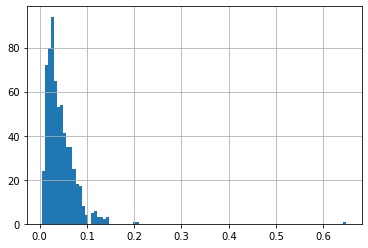

In [ ]:
weather_data['target_COV'].hist(bins=100)

There is a large outlier (has COV over 0.6) and a few outliers around 0.2. I will not use these in my EDA so that it doesn't throw stuff off.

In [ ]:
weather_data.query('target_COV < 0.175')[['Hot Summer Months','Cold Winter Months','Dry Summer Months','target_COV']].corr()

,Hot Summer Months,Cold Winter Months,Dry Summer Months,target_COV
Hot Summer Months,1.000000,-0.144535,0.189512,-0.002268
Cold Winter Months,-0.144535,1.000000,-0.165281,0.076452
Dry Summer Months,0.189512,-0.165281,1.000000,0.081703
target_COV,-0.002268,0.076452,0.081703,1.000000


The only variables that have any correlation at all (and doesn't have a lot) is 'Cold Winter Months' and 'Dry Summer Months'

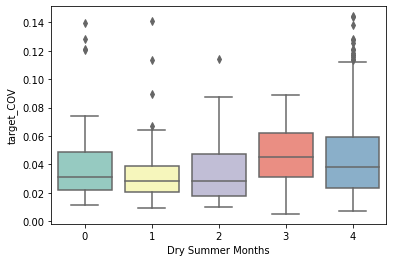

In [ ]:
sns.boxplot(x="Dry Summer Months", y="target_COV",
                 data=weather_data.query("target_COV < 0.175"), palette="Set3")

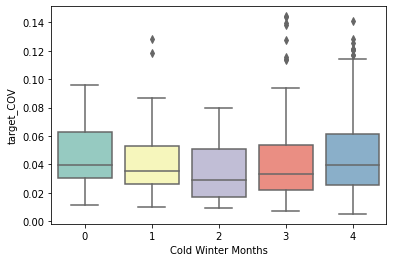

In [ ]:
sns.boxplot(x="Cold Winter Months", y="target_COV",
                 data=weather_data.query("target_COV < 0.175"), palette="Set3")

There is a slight upward trend, but at each level there are definitely lots of outlier years/states with high COVs.

### Now I want to look at other weather related items too such as each states mean and standard deviation temperature

In [ ]:
mean_temps = pd.read_csv('../weather/temperature_summary.csv').groupby(by='State').mean()
mean_temps['State'] = mean_temps.index
mean_temps = mean_temps.reset_index(drop=True)
mean_droughts = pd.read_csv('../weather/drought_summary.csv').groupby(by='State').mean()
mean_droughts['State'] = mean_droughts.index
mean_droughts = mean_droughts.reset_index(drop=True)

In [ ]:
# make the states into abbreviations
mean_temps['State'] = [us.states.lookup(s).abbr for s in mean_temps['State']]
mean_droughts['State'] = [us.states.lookup(s).abbr for s in mean_droughts['State']]

In [ ]:
# add the means by state to the weather_data dataframe so that the same state mean is used across all years
weather_data_mean_temps = pd.merge(weather_data[['Year','State','target_COV']],mean_temps,on='State')
weather_data_mean_droughts = pd.merge(weather_data[['Year','State','target_COV']],mean_droughts,on='State')

In [ ]:
# look at the correlations
weather_data_mean_temps.query('target_COV < 0.175')[weather_data_mean_temps.columns[2:]].corr()['target_COV']

target_COV                1.000000
Unnamed: 0                0.157273
Averages 1                0.069476
Standard Deviations 1    -0.016345
Averages 2                0.100801
Standard Deviations 2     0.064895
Averages 3                0.134255
Standard Deviations 3     0.169786
Averages 4                0.151353
Standard Deviations 4     0.315872
Averages 5                0.183749
Standard Deviations 5     0.133412
Averages 6                0.235833
Standard Deviations 6     0.185905
Averages 7                0.266620
Standard Deviations 7    -0.021143
Averages 8                0.250908
Standard Deviations 8     0.223830
Averages 9                0.187708
Standard Deviations 9     0.115157
Averages 10               0.142499
Standard Deviations 10   -0.057158
Averages 11               0.065724
Standard Deviations 11    0.149178
Averages 12               0.039775
Standard Deviations 12   -0.018072
x                        -0.149698
y                        -0.142755
Name: target_COV, dt

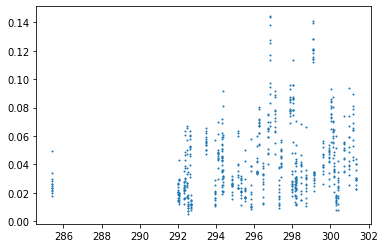

In [ ]:
# the variable with the highest correlation is the average july temperature
plt.scatter(weather_data_mean_temps.query('target_COV <0.175')['Averages 7'],weather_data_mean_temps.query('target_COV<0.175')['target_COV'],s=1)

In [ ]:
# look at the correlations
weather_data_mean_droughts.query('target_COV < 0.175')[weather_data_mean_droughts.columns[2:]].corr()['target_COV']

target_COV                1.000000
Unnamed: 0                0.157273
Averages 1                0.273062
Standard Deviations 1     0.055115
Averages 2                0.273560
Standard Deviations 2     0.124302
Averages 3                0.246348
Standard Deviations 3     0.083663
Averages 4                0.221000
Standard Deviations 4     0.131824
Averages 5                0.230428
Standard Deviations 5     0.062090
Averages 6                0.222548
Standard Deviations 6     0.018959
Averages 7                0.254539
Standard Deviations 7    -0.041439
Averages 8                0.299416
Standard Deviations 8     0.026416
Averages 9                0.298264
Standard Deviations 9     0.060056
Averages 10               0.275025
Standard Deviations 10    0.003508
Averages 11               0.254919
Standard Deviations 11    0.024218
Averages 12               0.300853
Standard Deviations 12   -0.021445
x                        -0.149698
y                        -0.142755
Name: target_COV, dt

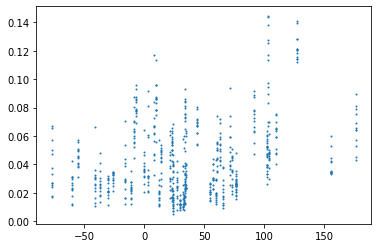

In [ ]:
# the variable with the highest correlation is the average december pdsi
plt.scatter(weather_data_mean_droughts.query('target_COV <0.175')['Averages 12'],weather_data_mean_droughts.query('target_COV<0.175')['target_COV'],s=1)

## Now do the same EDA but with weighted values

In [ ]:
weighted_months_summary = pd.read_csv('../weather/annual_weather_data_weighted.csv')

In [ ]:
weighted_weather_df = pd.merge(weather_data[['State','Year','target_COV']],weighted_months_summary[['State','Year','Hot Summer Months','Cold Winter Months','Dry Summer Months']], on=['Year','State'])

In [ ]:
weighted_weather_df.query('target_COV<0.175').corr()

,Year,target_COV,Hot Summer Months,Cold Winter Months,Dry Summer Months
Year,1.000000,-0.076401,0.114167,-0.230071,-0.141658
target_COV,-0.076401,1.000000,-0.142175,0.132776,0.109778
Hot Summer Months,0.114167,-0.142175,1.000000,-0.470273,-0.145456
Cold Winter Months,-0.230071,0.132776,-0.470273,1.000000,0.145159
Dry Summer Months,-0.141658,0.109778,-0.145456,0.145159,1.000000


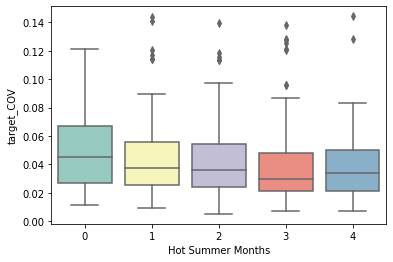

In [ ]:
sns.boxplot(x="Hot Summer Months", y="target_COV",
                 data=weighted_weather_df.query("target_COV < 0.175"), palette="Set3")

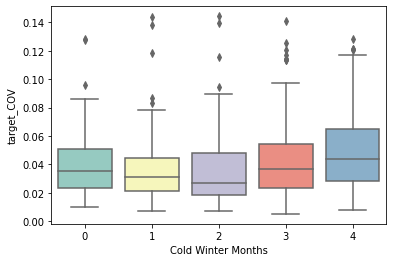

In [ ]:
sns.boxplot(x="Cold Winter Months", y="target_COV",
                 data=weighted_weather_df.query("target_COV < 0.175"), palette="Set3")

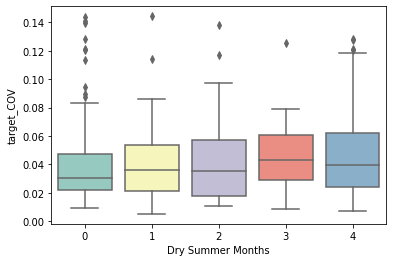

In [ ]:
sns.boxplot(x="Dry Summer Months", y="target_COV",
                 data=weighted_weather_df.query("target_COV < 0.175"), palette="Set3")

### Now look at state averages but weighted

In [ ]:
mean_temps_weighted = pd.read_csv('../weather/weighted_temperature_summary.csv').groupby(by='State').mean()
mean_temps_weighted['State'] = mean_temps_weighted.index
mean_temps_weighted = mean_temps_weighted.reset_index(drop=True)
mean_droughts_weighted = pd.read_csv('../weather/weighted_drought_summary.csv').groupby(by='State').mean()
mean_droughts_weighted['State'] = mean_droughts_weighted.index
mean_droughts_weighted = mean_droughts_weighted.reset_index(drop=True)

In [ ]:
# make the states into abbreviations
mean_temps_weighted['State'] = [us.states.lookup(s).abbr for s in mean_temps_weighted['State']]
mean_droughts_weighted['State'] = [us.states.lookup(s).abbr for s in mean_droughts_weighted['State']]

In [ ]:
# add the means by state to the weather_data dataframe so that the same state mean is used across all years
weather_data_mean_temps_weighted = pd.merge(weather_data[['Year','State','target_COV']],mean_temps_weighted,on='State')
weather_data_mean_droughts_weighted = pd.merge(weather_data[['Year','State','target_COV']],mean_droughts_weighted,on='State')

In [ ]:
# look at the correlations
weather_data_mean_temps_weighted.query('target_COV < 0.175')[weather_data_mean_temps_weighted.columns[2:]].corr()['target_COV']

target_COV                1.000000
Unnamed: 0                0.157273
Averages 1               -0.123083
Standard Deviations 1    -0.114710
Averages 2               -0.123067
Standard Deviations 2    -0.108414
Averages 3               -0.123002
Standard Deviations 3    -0.100763
Averages 4               -0.122838
Standard Deviations 4    -0.090611
Averages 5               -0.122739
Standard Deviations 5    -0.106379
Averages 6               -0.122759
Standard Deviations 6    -0.118204
Averages 7               -0.122808
Standard Deviations 7    -0.124404
Averages 8               -0.122854
Standard Deviations 8    -0.104517
Averages 9               -0.122819
Standard Deviations 9    -0.116524
Averages 10              -0.122774
Standard Deviations 10   -0.128879
Averages 11              -0.123027
Standard Deviations 11   -0.113397
Averages 12              -0.123135
Standard Deviations 12   -0.116062
x                        -0.149698
y                        -0.142755
Name: target_COV, dt

In [ ]:
# look at the correlations
weather_data_mean_droughts_weighted.query('target_COV < 0.175')[weather_data_mean_droughts_weighted.columns[2:]].corr()['target_COV']

target_COV                1.000000
Unnamed: 0                0.157273
Averages 1                0.014478
Standard Deviations 1    -0.105400
Averages 2                0.031265
Standard Deviations 2    -0.100529
Averages 3               -0.001650
Standard Deviations 3    -0.106746
Averages 4               -0.005037
Standard Deviations 4    -0.104383
Averages 5               -0.000260
Standard Deviations 5    -0.107880
Averages 6                0.022342
Standard Deviations 6    -0.111537
Averages 7                0.030129
Standard Deviations 7    -0.111768
Averages 8                0.083456
Standard Deviations 8    -0.108192
Averages 9                0.045142
Standard Deviations 9    -0.102371
Averages 10               0.010526
Standard Deviations 10   -0.107585
Averages 11              -0.012956
Standard Deviations 11   -0.106307
Averages 12               0.042803
Standard Deviations 12   -0.108170
x                        -0.149698
y                        -0.142755
Name: target_COV, dt

## Overall, weighting by population or log population only slightly increased correlations when they did. I think I need to go back through my data aggregation using these weights to make sure I did things correctly because I expected much  higher correlations and better results from the EDA. If I did do things correctly than I must find another way to take into account the spatial variability of weather.